In [1]:
#This notebook will let you run BBii-Decon in combination with a heuristic for measuring error in the deblurred image
#Dependencies are numpy, matplotlib, pypher, scipy, tifffile, time 
#Author: Graham Dellaire

import scipy.io
import matplotlib.pyplot as plt
import scipy.signal
import tifffile as tiff
from tifffile import imsave, imread
import numpy as np
from pypher.pypher import psf2otf
from scipy.stats import skew
from math import sqrt


#BBii function; Source: Fraser, Arnold, Dellaire 2014 https://ieeexplore.ieee.org/abstract/document/6816842

def bbii(b, PSF, N, x):
    ''' Python re-implementation of Matlab BBii functiond with heuristic
    
    Input:
    b - blurry , noisy image
    PSF - point spread function
    N - number of iterations
    x - original image
    
    '''
    
    # convert to numpy arrays
    PSF = np.array(PSF)
    b = np.array(b)
      
    alpha = np.zeros([N+1])
    proj = np.zeros([N])
    error = np.zeros([N])
    ffts = np.zeros([N])
    skewness = np.zeros([N])
    inc = np.zeros([N])
        
    K = psf2otf(PSF, b.shape)
    B = np.fft.fftn(b)

    y = b
    ybest = b
    min_e = 1.0
    g = np.zeros([y.shape[0], y.shape[1]])
    Y = np.fft.fftn(y)
    
    G = np.multiply(np.conj(K), (np.multiply(K, Y) - B))
        

    for k in range(1, N):
    
        diff = y - x # x must be original image, for calculating error
        error[k] = sqrt(np.matmul(diff.flatten().T, diff.flatten()) / np.matmul(x.flatten().T, x.flatten()) )
        

        if  k > 1 and error[k] < min_e and ffts[k] < 400: # why ffts[k] < 400?
            ybest = y
            min_e = error[k]
            print("improvement in error: ", k, error[k])


        gprev = g
        g = np.real(np.fft.ifftn(G))
  
        if k == 1:
            h = np.fft.ifftn(np.multiply(K,G)) #called Kg in my other code
            alpha[k] = np.matmul(g.flatten().T, g.flatten()) / np.matmul(h.flatten().T, h.flatten())
        else:
            dy = y.flatten() - yprev.flatten()
            dg = g.flatten() - gprev.flatten()
            alpha[k] = np.matmul(dy.T, dy) / np.matmul(dy.T, dg)
            
        yprev = y
        y = y - alpha[k]*g

        skewness[k] = skew(y.flatten())
        if k > 1 and skewness[k] >= skewness[k-1]:
            inc[k] = 1
            
        #print(min(y.flatten()) < 0.0) # solution is infeasible
        #print(inc[k] == 0) # skewness is not increasing (i.e. lower than observed in previous iteration)
        #print(k > 8) # have done at least 8 iterations
        #print(sum(inc[k-8:k-1]) < 3) # over the past 8 iterations, at most 2 increases in skewness have been observed
        #print('-----')
        
        if (min(y.flatten()) < 0.0 and inc[k] == 0 and k > 8 and sum(inc[k-8:k-1]) < 3):	# then project 
            y[y < 0] = 0.0
            Y = np.fft.fftn(y);
            G = np.multiply(np.conj(K), (np.multiply(K, Y) - B))
            proj[k] = 1
            
            if k == 1: # do we have to change this to be 0-indexed?
                ffts[k] = 6 
            else: 
                ffts[k] = ffts[k-1] + 2 
            
            skewness[k] = skew(y.flatten())
  
        else: #then don't project
            G = G - alpha[k] * (np.multiply(np.multiply(np.conj(K), K), G))
            if k == 1:
                ffts[k] = 5 
            else: 
                ffts[k] = ffts[k-1] + 1
                
    y[y < 0] = 0.0 #always project on last iteration
    return [error, ffts, skew, proj, min_e, ybest, y]
    


In [2]:
# Open blurry images to be deconvolved
image1 = tiff.imread('DAPI_blurred.tif')
image2 = tiff.imread('Actin3_blurred.tif')

# Open ground truth references images
image3 = tiff.imread('DAPI_GroundTruth.tif')
image4 = tiff.imread('Actin3_GroundTruth.tif')

PSF = tiff.imread('PSF.tif')



Original


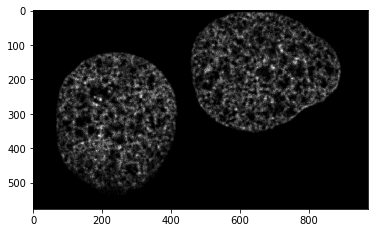

Blurred


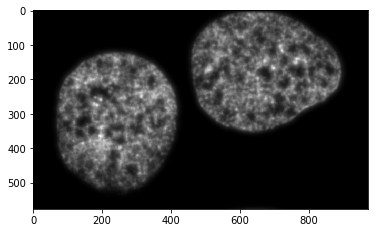

In [3]:
# see what the loaded images look like
print("Original")

plt.imshow(image3, cmap="gray")
plt.show()  

print("Blurred")
plt.imshow(image1, cmap="gray")
plt.show()    


C:\Users\GD\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: ComplexWarning: Casting complex values to real discards the imaginary part


Execution Time:
1.0980408191680908
seconds
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
Blurred Image


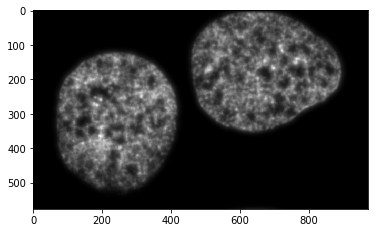

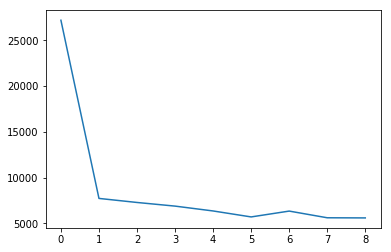

Image after:  10 iterations


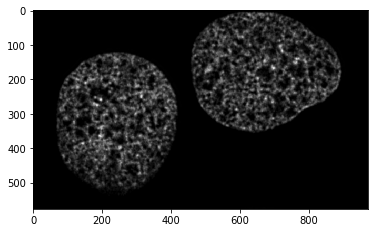

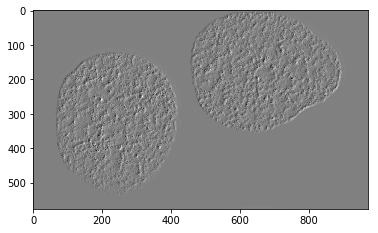

error in 10 iterations: 5580.914620382577


In [4]:
# Calling BBii function with Heuristic 

# Set the number of interations to interrogate
iter = 10


# start timing of BBii reconstruction
import time
start = time.time()

[error, ffts, skew, proj, min_e, ybest, y] = bbii(image1, PSF, iter, image3)

# end timing of BBii reconstruction
print("Execution Time:")
end = time.time()
print(end - start)
print("seconds")

print(proj)
print(min_e)

# see what the deblurred image looks like
# this is the image with the lowest error

print("Blurred Image")
plt.imshow(image1, cmap="gray")
plt.show()  

#plot the error
plt.plot(error[1:])
plt.show()

print("Image after: ", iter, "iterations")
# this is the image from the last iteration
plt.imshow(y, cmap="gray")
plt.show() 

Z = y - image3

plt.imshow(Z, cmap="gray")
plt.show()

Max_error = sqrt(np.matmul(Z.flatten().T, Z.flatten()) / np.matmul(image3.flatten().T, image3.flatten()) )

print("error in", iter, "iterations:", Max_error)


C:\Users\GD\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: ComplexWarning: Casting complex values to real discards the imaginary part


Execution Time:
0.565732479095459
seconds
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
Blurred Image


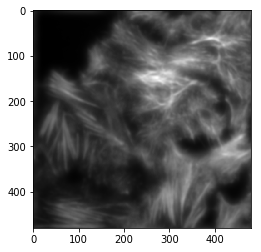

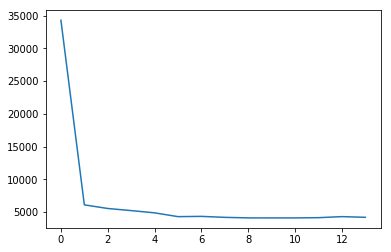

Image after:  15 iterations


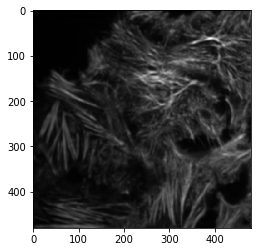

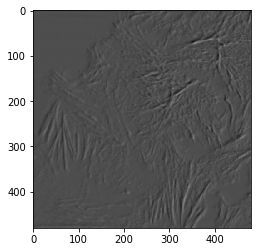

error in 15 iterations: 4170.703537773933


In [5]:
# Calling BBii function with Heuristic 

#Set the number of interations to interrogate
iter = 15

# start timing of BBii reconstruction
import time
start = time.time()

[error, ffts, skew, proj, min_e, ybest, y] = bbii(image2, PSF, iter, image4)

# end timing of BBii reconstruction
print("Execution Time:")
end = time.time()
print(end - start)
print("seconds")

print(proj)
print(min_e)

# see what the deblurred image looks like
# this is the image with the lowest error

print("Blurred Image")
plt.imshow(image2, cmap="gray")
plt.show()  

#plot the error
plt.plot(error[1:])
plt.show()

print("Image after: ", iter, "iterations")
# this is the image from the last iteration
plt.imshow(y, cmap="gray")
plt.show() 

Z = y - image4

plt.imshow(Z, cmap="gray")
plt.show()

Max_error = sqrt(np.matmul(Z.flatten().T, Z.flatten()) / np.matmul(image4.flatten().T, image4.flatten()) )

print("error in", iter, "iterations:", Max_error)
